In [4]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import time
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###
# Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # For Directml Gpu Configurations
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

# # Font update global for all plots
# plt.rcParams.update({"font.size": 18})

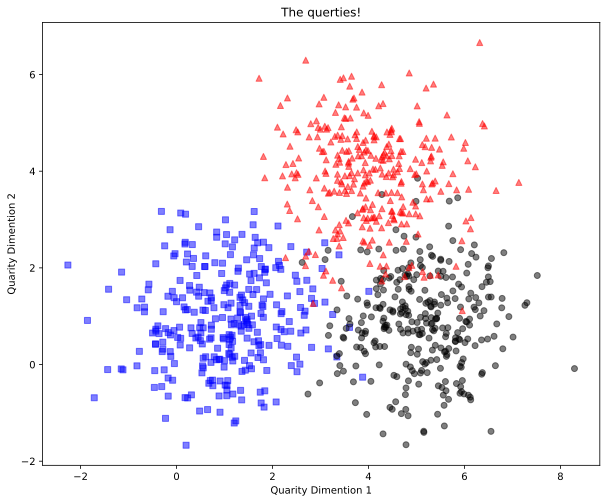

In [5]:
# Create and inspect the data

nPerCluster = 300  ## Change the value to 50 and then 1000 to see the effect on the learning performance
blur = 1

A = [1, 1]
B = [5, 1]
C = [4, 4]

# Generate the data
a = [
    A[0] + np.random.randn(nPerCluster) * blur,
    A[1] + np.random.randn(nPerCluster) * blur,
]
b = [
    B[0] + np.random.randn(nPerCluster) * blur,
    B[1] + np.random.randn(nPerCluster) * blur,
]
c = [
    C[0] + np.random.randn(nPerCluster) * blur,
    C[1] + np.random.randn(nPerCluster) * blur,
]

# True labels
labels_np = np.hstack(
    (np.zeros((nPerCluster)), np.ones((nPerCluster)), 1 + np.ones((nPerCluster)))
)

# Concat into a matrix
data_np = np.hstack((a, b, c)).T

# Convert to pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long()  # note: Long format is for Cross Entropy Loss

# Show the data
fig = plt.figure(figsize=(10, 8))
plt.plot(
    data[np.where(labels.cpu() == 0)[0], 0].cpu(),
    data[np.where(labels.cpu() == 0)[0], 1].cpu(),
    "bs",
    alpha=0.5,
)
plt.plot(
    data[np.where(labels.cpu() == 1)[0], 0].cpu(),
    data[np.where(labels.cpu() == 1)[0], 1].cpu(),
    "ko",
    alpha=0.5,
)
plt.plot(
    data[np.where(labels.cpu() == 2)[0], 0].cpu(),
    data[np.where(labels.cpu() == 2)[0], 1].cpu(),
    "r^",
    alpha=0.5,
)
plt.title("The querties!")
plt.xlabel("Quarity Dimention 1")
plt.ylabel("Quarity Dimention 2")
plt.show()

In [6]:
# Use scikitlearn train_test_split to split the data
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.1
)

# Convert data into pytorch dataset
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# Finally translate it into dataloader objects
batchsize = 16
train_loader = DataLoader(
    train_dataset,
    batch_size=batchsize,
    shuffle=True,
    drop_last=True,
    generator=torch.Generator(device),
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_dataset.tensors[0].shape[0],
    generator=torch.Generator(device),
)

In [7]:
# how many batches are there?

print(f"There are {len(train_loader)} batches, each with {batchsize} samples.")

There are 50 batches, each with 16 samples.


In [15]:
# Create model function
def createTheQuertyNet(optimAlgo, lr):
    # Class for the QuertyNet
    class QuertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input Layer
            self.input = nn.Linear(2, 8)

            # Hidden Layers
            self.hidden1 = nn.Linear(8, 8)
            self.hidden2 = nn.Linear(8, 8)
            # Output Layer
            self.output = nn.Linear(8, 3)

        # Forwar Pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.hidden1(x))
            x = F.relu(self.hidden2(x))

            return self.output(x)

    # Model Instance
    net = QuertyNet()

    # Loss Function
    lossFun = nn.CrossEntropyLoss()

    # Optimizer
    optimFun = getattr(torch.optim, optimAlgo)
    optimizer = optimFun(net.parameters(), lr=lr)

    return net, lossFun, optimizer

In [16]:
# test the model with optimizer type as input

# try 'SGD', 'RMSprop', and 'Adam'
optim = createTheQuertyNet("RMSprop", lr=0.01)[2]
optim

RMSprop (
Parameter Group 0
    alpha: 0.99
    capturable: False
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    weight_decay: 0
)

In [17]:
nEpochs = 50


# Function to train the model
def trainTheModel(optimAlgo, lr):
    # Create a new model
    net, lossFun, optimizer = createTheQuertyNet(optimAlgo, lr)

    # Initialize losses
    losses = torch.zeros(nEpochs)
    trainAcc = []
    testAcc = []

    # The Loop
    for epoch in range(nEpochs):

        # Switch to training mode
        net.train()

        # Loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # Forward pass
            yHat = net(X)
            loss = lossFun(yHat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss for the batch
            batchLoss.append(loss.item())

            # Comput accuracy
            matches = torch.argmax(yHat, axis=1) == y
            matchesNumeric = matches.float()
            batchAcc.append(100 * (torch.mean(matchesNumeric)).cpu())

            # End of batch loop
        # Average training accuracy across the batches
        trainAcc.append(np.mean(batchAcc))

        # Average losses across batches
        losses[epoch] = np.mean(batchLoss)

        # Test Accuracy
        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
        testAcc.append(
            100 * (torch.mean((torch.argmax(yHat, axis=1) == y).float())).cpu()
        )

    # End of epoch

    # Function Output
    return trainAcc, testAcc, losses, net

In [29]:
# a function that plots the results
def plotTheResults(optimizerType, lr):

    # compute accuracy over entire dataset (train+test)
    yHat = net(data)
    predictions = torch.argmax(yHat, axis=1)
    accuracy = (predictions == labels).float()
    totalAcc = torch.mean(100 * accuracy).item()

    # and accuracy by group
    accuracyByGroup = np.zeros(3)
    for i in range(3):
        accuracyByGroup[i] = 100 * torch.mean(accuracy[labels == i])

    # create the figure
    fig, ax = plt.subplots(2, 2, figsize=(10, 6))

    # plot the loss function
    ax[0, 0].plot(losses.cpu().detach())
    ax[0, 0].set_ylabel("Loss")
    ax[0, 0].set_xlabel("epoch")
    ax[0, 0].set_title(f"{optimizerType}: Losses")

    # plot the accuracy functions
    ax[0, 1].plot(trainAcc, label="Train")
    ax[0, 1].plot(testAcc, label="Test")
    ax[0, 1].set_ylabel("Accuracy (%)")
    ax[0, 1].set_xlabel("Epoch")
    ax[0, 1].set_title(f"{optimizerType}: Accuracy at lr {lr}")
    ax[0, 1].legend()

    # plot overall accuracy by group
    ax[1, 0].bar(range(3), accuracyByGroup)
    ax[1, 0].set_ylim([np.min(accuracyByGroup) - 5, np.max(accuracyByGroup) + 5])
    ax[1, 0].set_xticks([0, 1, 2])
    ax[1, 0].set_xlabel("Group")
    ax[1, 0].set_ylabel("Accuracy (%)")
    ax[1, 0].set_title(f"{optimizerType}: Accuracy by group at lr {lr}")

    # scatterplot of correct and incorrect labeled data
    colorShapes = ["bs", "ko", "g^"]  # data markers
    for i in range(3):
        # plot all data points
        ax[1, 1].plot(
            data[labels == i, 0].cpu(),
            data[labels == i, 1].cpu(),
            colorShapes[i],
            alpha=0.3,
            label=f"Group {i}",
        )

        # cross-out the incorrect ones
        idxErr = (accuracy == 0) & (labels == i)
        ax[1, 1].plot(data[idxErr, 0].cpu(), data[idxErr, 1].cpu(), "rx")

    ax[1, 1].set_title(f"{optimizerType}: Total accuracy: {totalAcc:.2f}% at lr {lr}")
    ax[1, 1].set_xlabel("qwerty dimension 1")
    ax[1, 1].set_ylabel("qwerty dimension 2")
    ax[1, 1].legend()

    plt.tight_layout()
    plt.show()

In [43]:
# now run through all of them
optimTypes = ["SGD", "RMSprop", "Adam"]
# average performance
lrs = np.logspace(np.log10(0.0001), np.log10(0.1), 20)
testAccs = np.zeros((len(lrs), len(optimTypes)))
for i, opto in enumerate(optimTypes):
    lrTestAcc = []
    for j, lr in enumerate(lrs):
        trainAcc, testAcc, losses, net = trainTheModel(opto, lr)
        # plotTheResults(opto, lr)
        # store the final results
        train = np.mean(trainAcc[-10:])
        test = np.mean(testAcc[-10:])
        testAccs[j, i] = test

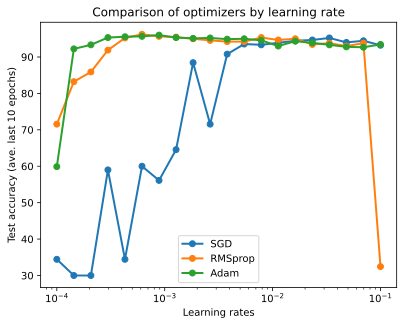

In [44]:
plt.plot(lrs, testAccs, 'o-', linewidth=2)
plt.legend(optimTypes)
plt.xlabel('Learning rates')
plt.ylabel('Test accuracy (ave. last 10 epochs)')
plt.xscale('log')
plt.title('Comparison of optimizers by learning rate')
plt.show()